# Data Prep

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#pandas profiling for EDA
from pandas_profiling import ProfileReport
import gc

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor


In [252]:
# Read in train data
app_train = pd.read_csv('C:/Users/User/Desktop/home-credit-default-risk/application_train.csv')
# Read in test data 
app_test = pd.read_csv('C:/Users/User/Desktop/home-credit-default-risk/application_test.csv')

# EDA

In [253]:
#Data frame at a glance
app_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [254]:
#profile report
trainprofile = ProfileReport(app_train, minimal=True)
trainprofile.to_widgets()

In [255]:
#how many unique classes do we have for categotical features
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [256]:
#list coloumns with most missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(30)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


## Visualizing Missing Data

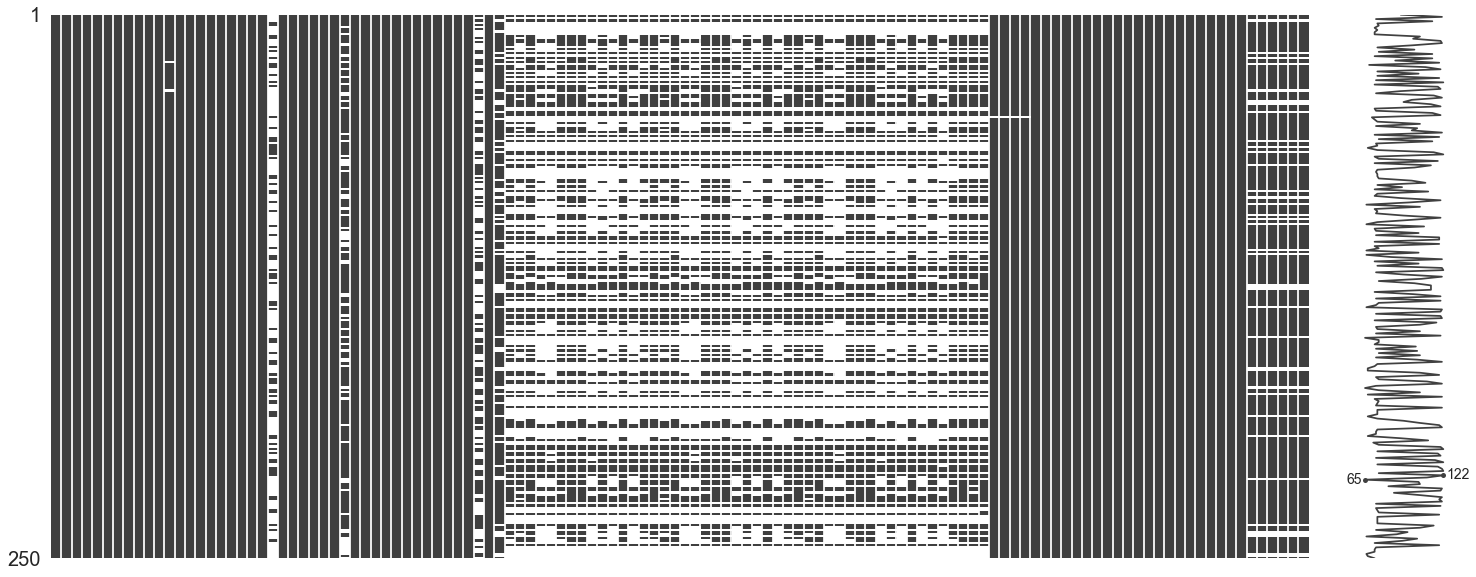

In [257]:
 import missingno as msno
%matplotlib inline
msno.matrix(app_train.sample(250))

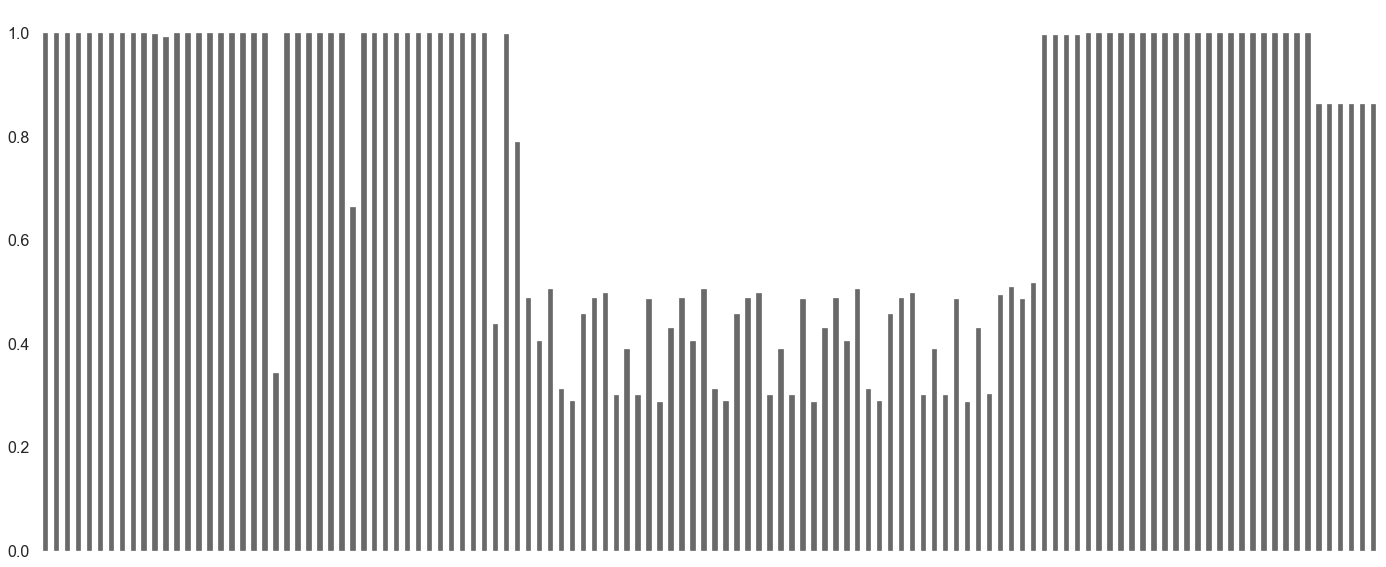

In [258]:
 msno.bar(app_train.sample(1000))

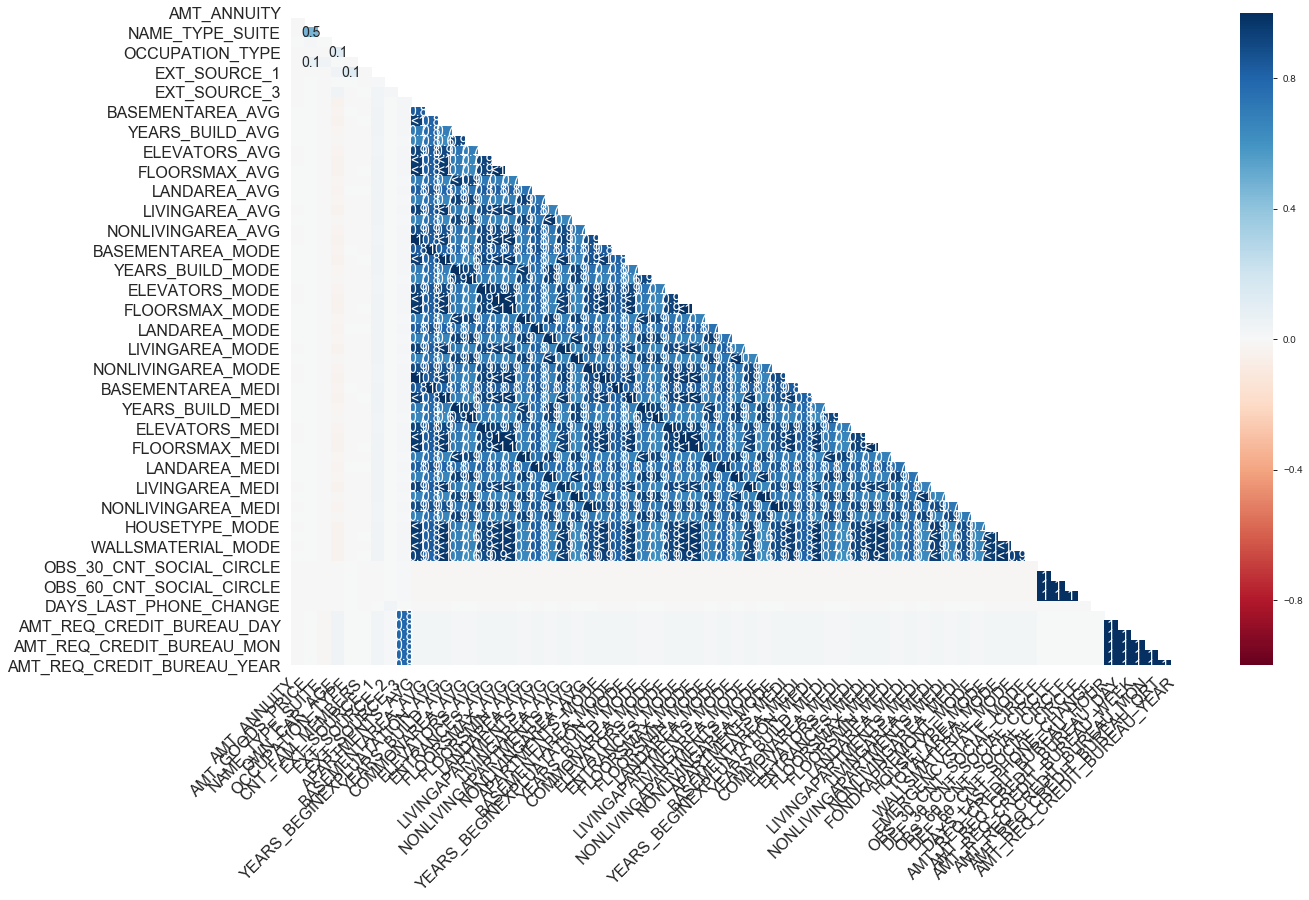

In [259]:
#heatmap
msno.heatmap(app_train)

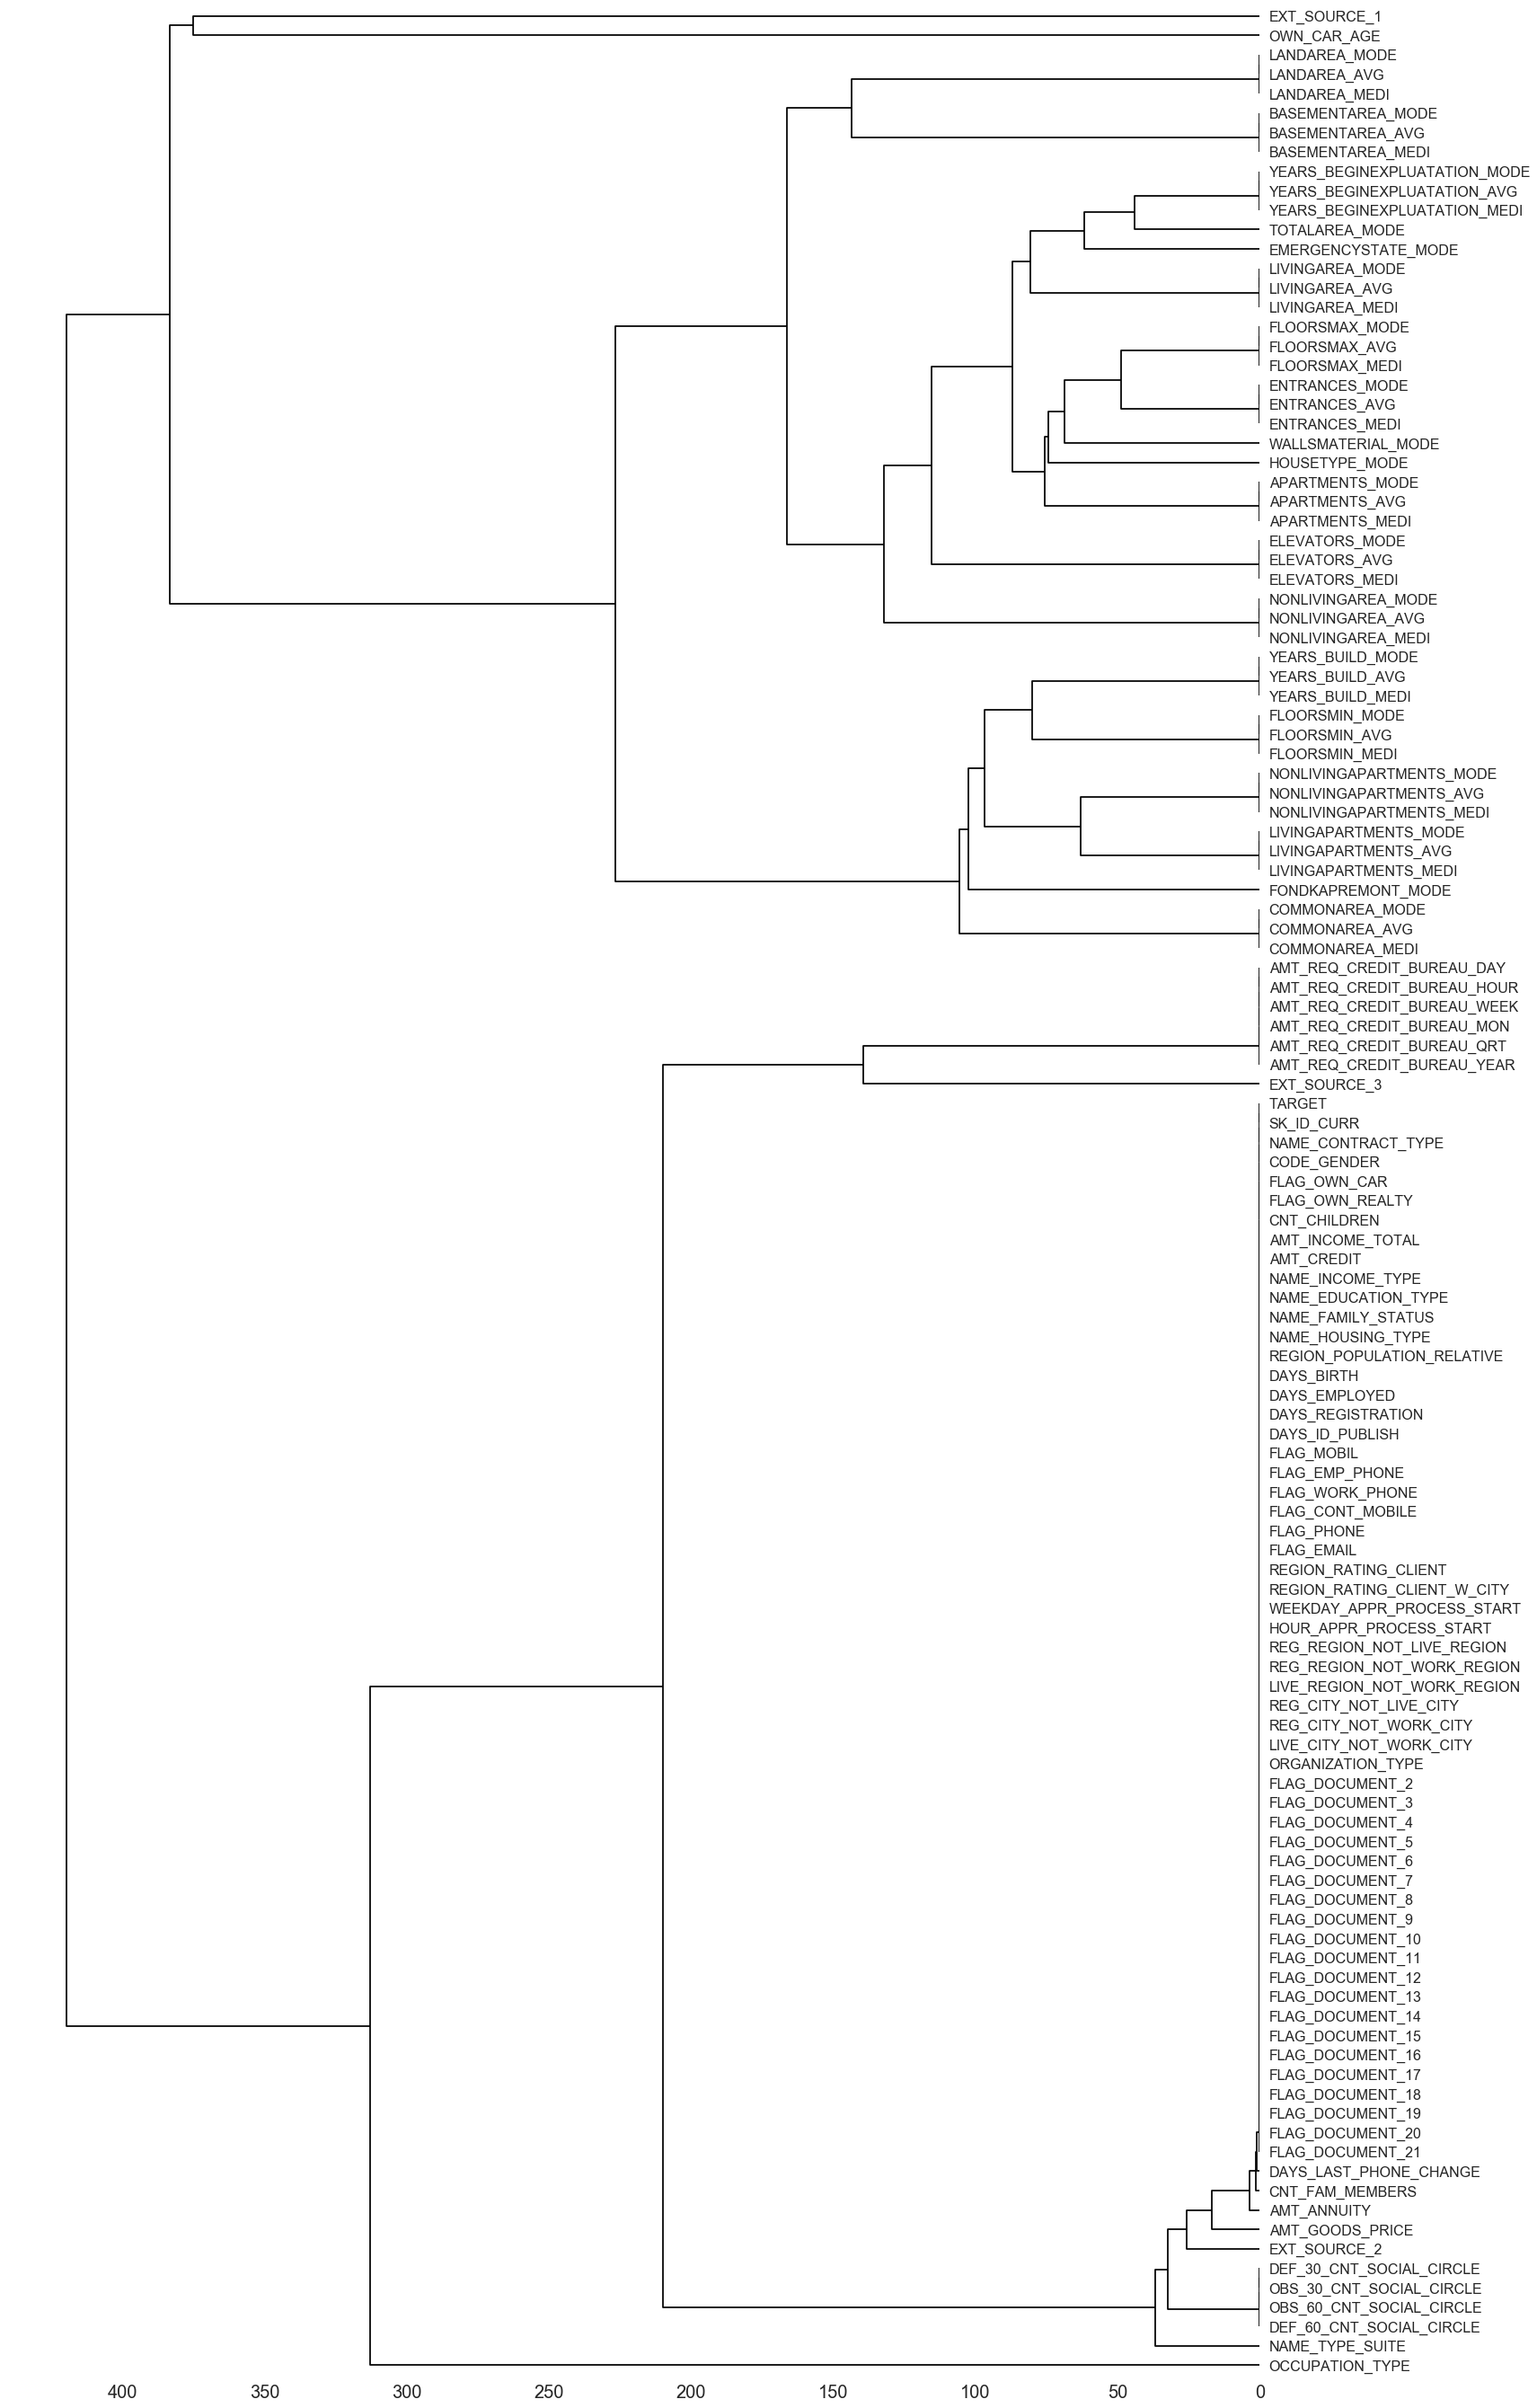

In [260]:
#Dendogram
msno.dendrogram(app_train)

## Data Cleaning

In [261]:
# Fixing incorrect data in Days Employed

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

In [262]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [263]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 240)


In [264]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


In [265]:

# Imputing the data by using the median of each feature to replace relative data
app_train[app_train.columns.tolist()] = SimpleImputer(strategy='median').fit_transform(app_train[app_train.columns.tolist()])
app_test[app_test.columns.tolist()] = SimpleImputer(strategy='median').fit_transform(app_test[app_test.columns.tolist()])


In [266]:
app_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 240 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(240)
memory usage: 89.3 MB


# Feature Selection

In [267]:
#stratified sampling 
application_sample1 = app_train.loc[app_train.TARGET==1].sample(frac=0.1, replace=False)
print('label 1 sample size:', str(application_sample1.shape[0]))
application_sample0 = app_train.loc[app_train.TARGET==0].sample(frac=0.1, replace=False)
print('label 0 sample size:', str(application_sample0.shape[0]))
application = pd.concat([application_sample1, application_sample0], axis=0).sort_values('SK_ID_CURR')

label 1 sample size: 2482
label 0 sample size: 28269


In [268]:
application.shape

(30751, 241)

In [269]:
X = application.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = application.TARGET
feature_name = X.columns.tolist()

## Filter

### Pearson Correlation

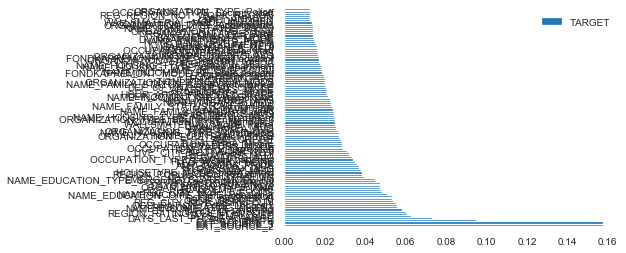

In [11]:
def pcorr(data):
    corrdf = pd.DataFrame(data[data.columns[1:]].corr()['TARGET'][:])
    corrdf = corrdf.drop('TARGET')
    corrdf['TARGET'] = np.abs(corrdf['TARGET'])
    corrdf_graph = corrdf.sort_values('TARGET', ascending = False)
    return corrdf_graph[:100].plot.barh()
pcorr(application)

In [270]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-75:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y)

In [271]:
cor_list = []
for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

In [272]:
cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-75:]].columns.tolist()


## Wrapper

### Recursive Feature Elimination 

In [273]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
X_norm = MinMaxScaler().fit_transform(X)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=75, step=5, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
Fitting estimator with 174 features.
Fitting estimator with 169 features.
Fitting estimator with 164 features.
Fitting estimator with 159 features.
Fitting estimator with 154 features.
Fitting estimator with 149 features.
Fitting estimator with 144 features.
Fitting estimator with 139 features.
Fitting estimator with 134 features.
Fitting estimator with 129 features.
Fitting estimator with 124 features.
Fitting estimator with 119 features.
Fitting estimator with 114 features.
Fitting estimator with 109 features.
F

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=75, step=5, verbose=5)

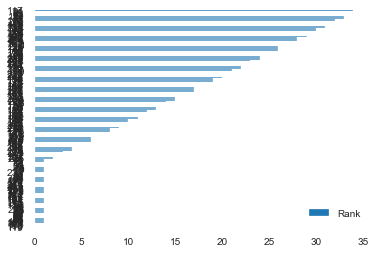

In [274]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
ranking = rfe_selector.ranking_

rfe_lists = {'Feature Name': feature_name, 'Rank':ranking}
rfe_total = pd.DataFrame(rfe_lists)
rfe_graph = rfe_total.sort_values('Rank', ascending = True)
rfe_graph.plot.barh()


## Embedded

### Random Forrest


In [275]:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=75), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

98 selected features


In [276]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'RFE':rfe_support, 
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(75)

,Feature,Pearson,RFE,Random Forest,Total
1,TOTALAREA_MODE,True,True,True,3
2,REGION_RATING_CLIENT_W_CITY,True,True,True,3
3,NONLIVINGAREA_MODE,True,True,True,3
4,NAME_EDUCATION_TYPE_Secondary / secondary special,True,True,True,3
5,FLOORSMAX_MODE,True,True,True,3
6,FLAG_OWN_CAR,True,True,True,3
7,FLAG_DOCUMENT_3,True,True,True,3
8,EXT_SOURCE_3,True,True,True,3
9,EXT_SOURCE_2,True,True,True,3
10,EXT_SOURCE_1,True,True,True,3


In [19]:
feature_names = feature_selection_df['Feature'].head(75)
feature_name_list = []
for i in range(1,76):
    cor = feature_names[i]
    feature_name_list.append(cor)
feature_name_list


['TOTALAREA_MODE',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'NONLIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'FLOORSMAX_MEDI',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED',
 'APARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'REG_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'REGION_POPULATION_RELATIVE',
 'ORGANIZATION_TYPE_Transport: type 3',
 'ORGANIZATION_TYPE_Self-employed',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'OCCUPATION_TYPE_Low-skill Laborers',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_Core staff',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NAME_INCOME_TYPE_Working',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_HOUSING_TYPE_With parents

In [277]:
app_train_feature = app_train[feature_name_list]
app_train_feature["TARGET"]=app_train["TARGET"]


In [278]:
app_train_feature.head(5)

,TOTALAREA_MODE,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NONLIVINGAREA_MEDI,LIVINGAREA_MODE,FLOORSMAX_MEDI,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DEF_30_CNT_SOCIAL_CIRCLE,...,COMMONAREA_AVG,CODE_GENDER_M,CODE_GENDER_F,AMT_REQ_CREDIT_BUREAU_QRT,AMT_INCOME_TOTAL,AMT_ANNUITY,YEARS_BUILD_MODE,YEARS_BUILD_MEDI,YEARS_BUILD_AVG,TARGET
0,0.0149,2.0,2.0,0.0000,0.0198,0.0833,0.139376,0.262949,0.083037,2.0,...,0.0143,1.0,0.0,0.0,202500.0,24700.5,0.6341,0.6243,0.6192,1.0
1,0.0714,1.0,1.0,0.0100,0.0554,0.2917,0.535276,0.622246,0.311267,0.0,...,0.0605,0.0,1.0,0.0,270000.0,35698.5,0.8040,0.7987,0.7960,0.0
2,0.0688,2.0,2.0,0.0031,0.0731,0.1667,0.729567,0.555912,0.505998,0.0,...,0.0211,1.0,0.0,0.0,67500.0,6750.0,0.7648,0.7585,0.7552,0.0
3,0.0688,2.0,2.0,0.0031,0.0731,0.1667,0.535276,0.650442,0.505998,0.0,...,0.0211,0.0,1.0,0.0,135000.0,29686.5,0.7648,0.7585,0.7552,0.0
4,0.0688,2.0,2.0,0.0031,0.0731,0.1667,0.535276,0.322738,0.505998,0.0,...,0.0211,1.0,0.0,0.0,121500.0,21865.5,0.7648,0.7585,0.7552,0.0


## Model 

In [279]:
#testing linear regression before balancing data for comparison
from sklearn.model_selection import train_test_split
train, test = train_test_split(app_train_feature, test_size=0.2)
print(train.shape)
print(test.shape)
train_label = train['TARGET']
train = train.drop(['TARGET'], axis=1)
print(train.shape)
print(train_label.shape)
test_label = test['TARGET']
test = test.drop(['TARGET'], axis=1)
print(test.shape)
print(test_label.shape)
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=10, random_state=0)
clf.fit(train, train_label)

clf_pred_train = clf.predict_proba(train)[:, 1]
clf_pred_train_class = clf.predict(train)
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
prf = precision_recall_fscore_support(train_label, clf_pred_train_class, average = 'weighted')
print("Train AUC Score for probability of Target = 1:", roc_auc_score(train_label, clf_pred_train))
print("Train AUC Score for class prediction:", roc_auc_score(train_label, clf_pred_train_class))
print("Train Accuracy Score:", balanced_accuracy_score(train_label,clf_pred_train_class))
print("Weighted Train Precision Score:",prf[0])
print("Weighted Train Recall Score:",prf[1])
print("Weighted Train f1 Score:",prf[2])

(246008, 76)
(61503, 76)
(246008, 75)
(246008,)
(61503, 75)
(61503,)
Train AUC Score for probability of Target = 1: 0.6319663013057228
Train AUC Score for class prediction: 0.4999911580715754
Train Accuracy Score: 0.4999911580715754
Weighted Train Precision Score: 0.8454091078435547
Weighted Train Recall Score: 0.9194457090826315
Weighted Train f1 Score: 0.8808744710003443


### Balancing the data using SMOTE

In [280]:
X = app_train_feature.drop(['TARGET'], axis=1)
y = app_train_feature.TARGET
feature_name = X.columns.tolist()

In [281]:
pip install imbalanced-learn --user


Note: you may need to restart the kernel to use updated packages.


In [282]:
import imblearn

import sklearn
from sklearn import datasets
from sklearn.datasets import make_classification
import collections
from collections import Counter
from numpy import where
from matplotlib import pyplot

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [283]:
counter = Counter(y)
print(counter)

Counter({0.0: 282686, 1.0: 24825})


In [284]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [285]:
X, y = pipeline.fit_resample(X, y)


In [286]:
counter = Counter(y)
print(counter)


Counter({0.0: 56536, 1.0: 28268})


### Splitting data into Train & Test

In [287]:
app_train_feature = X
app_train_feature['TARGET'] = y
app_train_feature.shape

(84804, 76)

In [288]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(app_train_feature, test_size=0.2)
print(train.shape)
print(test.shape)

(67843, 76)
(16961, 76)


In [289]:
train_label = train['TARGET']
train = train.drop(['TARGET'], axis=1)
print(train.shape)
print(train_label.shape)

(67843, 75)
(67843,)


In [290]:
test_label = test['TARGET']
test = test.drop(['TARGET'], axis=1)
print(test.shape)
print(test_label.shape)

(16961, 75)
(16961,)


In [33]:
import time

start = time.time()

end = time.time()
print('training time:', str(round((end - start))), 'secs')

training time: 0 secs


### Logistic Regression 

In [291]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=10, random_state=0)
clf.fit(train, train_label)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=0, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [292]:
import time
for _ in range(10):
    start = time.time()
    clf.fit(train, train_label)
    end = time.time()
    print('training time:', str(round((end - start))), 'secs')

training time: 37 secs
training time: 38 secs
training time: 38 secs
training time: 37 secs
training time: 37 secs
training time: 39 secs
training time: 37 secs
training time: 36 secs
training time: 37 secs
training time: 37 secs


#### Classification on Train 

In [293]:
clf_pred_train = clf.predict_proba(train)[:, 1]
clf_pred_train_class = clf.predict(train)


In [294]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(train_label, clf_pred_train_class).ravel()
tn, fp, fn, tp

(44550, 646, 21798, 849)

In [295]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
prf = precision_recall_fscore_support(train_label, clf_pred_train_class, average = 'weighted')
print("Train AUC Score for probability of Target = 1:", roc_auc_score(train_label, clf_pred_train))
print("Train AUC Score for class prediction:", roc_auc_score(train_label, clf_pred_train_class))
print("Train Accuracy Score:", balanced_accuracy_score(train_label,clf_pred_train_class))
print("Weighted Train Precision Score:",prf[0])
print("Weighted Train Recall Score:",prf[1])
print("Weighted Train f1 Score:",prf[2])

Train AUC Score for probability of Target = 1: 0.633232875889089
Train AUC Score for class prediction: 0.5115975543843708
Train Accuracy Score: 0.5115975543843707
Weighted Train Precision Score: 0.6368875089960011
Weighted Train Recall Score: 0.6691773653877334
Weighted Train f1 Score: 0.5556191473919503


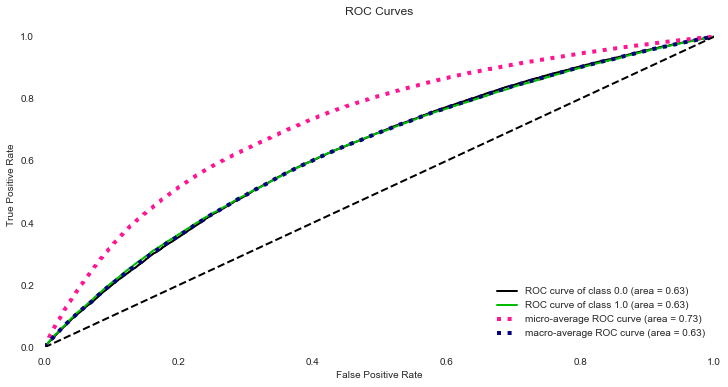

In [296]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(train_label, clf.predict_proba(train), figsize=(12,6))
plt.show();

#### Classificaiton on Test

In [37]:
clf_pred_test = clf.predict_proba(test)[:, 1]
clf_pred_test_class = clf.predict(test)



Test AUC Score for probabiltity of Target = 1: 0.6327460519336223


In [70]:
tn, fp, fn, tp = confusion_matrix(test_label, clf_pred_test_class).ravel()
tn, fp, fn, tp

(11135, 147, 5487, 192)

In [83]:
prf = precision_recall_fscore_support(test_label, clf_pred_test_class, average = 'weighted')

print("Test AUC Score for probabiltity of Target = 1:", roc_auc_score(test_label, clf_pred_test))
print("Test AUC Score for class prediction:", roc_auc_score(test_label, clf_pred_test_class))
print("Train Accuracy Score:", balanced_accuracy_score(test_label,clf_pred_test_class))
print("Weighted Train Precision Score:",prf[0])
print("Weighted Train Recall Score:",prf[1])
print("Weighted Train f1 Score:",prf[2])

Test AUC Score for probabiltity of Target = 1: 0.6327460519336223
Test AUC Score for class prediction: 0.5103895822347385
Train Accuracy Score: 0.5103895822347384
Weighted Train Precision Score: 0.6352328148614622
Weighted Train Recall Score: 0.667826189493544
Weighted Train f1 Score: 0.5522350891045158


In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(test_label, clf.predict_proba(test), figsize=(12,6))
plt.show();

### Random Forest

In [103]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(app_train_feature, test_size=0.2)
print(train.shape)
print(test.shape)
train_label = train['TARGET']
train = train.drop(['TARGET'], axis=1)
print(train.shape)
print(train_label.shape)
test_label = test['TARGET']
test = test.drop(['TARGET'], axis=1)
print(test.shape)
print(test_label.shape)


(67843, 76)
(16961, 76)
(67843, 75)
(67843,)
(16961, 75)
(16961,)


In [104]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
clf.fit(train, train_label)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [87]:
for _ in range(10):
    start = time.time()
    clf.fit(train, train_label)
    end = time.time()
    print('training time:', str(round((end - start))), 'secs')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


training time: 4 secs


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s


training time: 4 secs


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


#### Classfication on Train

In [105]:
from sklearn.model_selection import cross_val_predict
clf_pred_train = cross_val_predict(clf, train, train_label, cv = 5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]:

In [111]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(train_label, clf_pred_train).ravel()
tn, fp, fn, tp

(41537, 3672, 13844, 8790)

In [113]:
prf = precision_recall_fscore_support(train_label, clf_pred_train, average = 'weighted')
print("Train AUC Score for class prediction:", roc_auc_score(train_label, clf_pred_train))
print("Train Accuracy Score:", balanced_accuracy_score(train_label,clf_pred_train))
print("Weighted Train Precision Score:",prf[0])
print("Weighted Train Recall Score:",prf[1])
print("Weighted Train f1 Score:",prf[2])

Train AUC Score for class prediction: 0.6535655193165444
Train Accuracy Score: 0.6535655193165444
Weighted Train Precision Score: 0.7351168445398552
Weighted Train Recall Score: 0.7418156626328435
Weighted Train f1 Score: 0.7174546501552151


#### Classification on Test

In [115]:
clf_pred_test = clf.predict_proba(test)[:, 1]
clf_pred_test_class = clf.predict(test)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [117]:
prf = precision_recall_fscore_support(test_label, clf_pred_test_class, average = 'weighted')
tn, fp, fn, tp = confusion_matrix(test_label, clf_pred_test_class).ravel()
print(tn, fp, fn, tp)
print("Test AUC Score for probabiltity of Target = 1:", roc_auc_score(test_label, clf_pred_test))
print("Test AUC Score for class prediction:", roc_auc_score(test_label, clf_pred_test_class))
print("Train Accuracy Score:", balanced_accuracy_score(test_label,clf_pred_test_class))
print("Weighted Train Precision Score:",prf[0])
print("Weighted Train Recall Score:",prf[1])
print("Weighted Train f1 Score:",prf[2])

Test AUC Score for probabiltity of Target = 1: 0.7739529018267711
Test AUC Score for class prediction: 0.6617826023745212
Train Accuracy Score: 0.6617826023745212
Weighted Train Precision Score: 0.7403651195596834
Weighted Train Recall Score: 0.7472436766700077
Weighted Train f1 Score: 0.7252420704518026


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


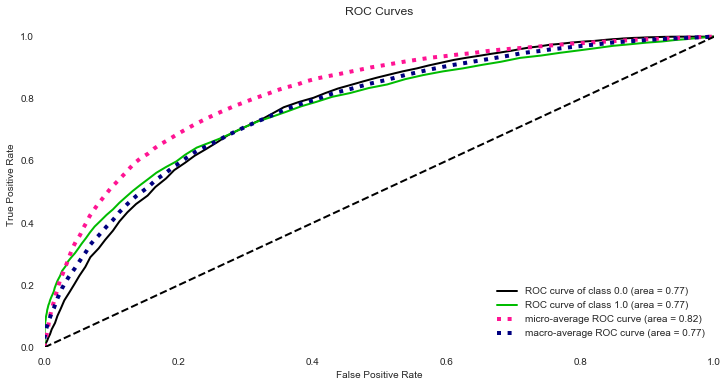

In [121]:
#conda install -c conda-forge scikit-plot

import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(test_label, clf.predict_proba(test), figsize=(12,6))
plt.show();

### Light GBM

In [198]:
import setuptools
import wheel
import scipy

In [199]:
#conda install -c conda-forge/label/cf201901 lightgbm 

import lightgbm as lgb


In [222]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(app_train_feature, test_size=0.2)
print(train.shape)
print(test.shape)
train_label = train['TARGET']
train = train.drop(['TARGET'], axis=1)
print(train.shape)
print(train_label.shape)
test_label = test['TARGET']
test = test.drop(['TARGET'], axis=1)
print(test.shape)
print(test_label.shape)

(67843, 76)
(16961, 76)
(67843, 75)
(67843,)
(16961, 75)
(16961,)


In [223]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train, label = train_label)
test_set = lgb.Dataset(test, label = test_label)

In [224]:
 N_FOLDS = 5
MAX_EVALS = 5
    #Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

The maximium ROC AUC in cross validation was 0.78237 with std of 0.00594.
The ideal number of iterations was 141.


#### Classification on Train

In [ ]:
for _ in range(10):
    start = time.time()
    model.fit(train, train_label)
    end = time.time()
    print('training time:', str(round((end - start))), 'secs')

In [203]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train, train_label)
clf_pred_train = model.predict_proba(train)[:, 1]
clf_pred_train_class = model.predict(train) 
clf_pred_test = model.predict_proba(test)[:, 1]
clf_pred_test_class = model.predict(test) 



In [204]:
prf = precision_recall_fscore_support(train_label, clf_pred_train_class, average = 'weighted')
tn, fp, fn, tp = confusion_matrix(train_label, clf_pred_train_class).ravel()
print(tn, fp, fn, tp)
print("Train AUC Score for probability of Target = 1:", roc_auc_score(train_label, clf_pred_train))
print("Train AUC Score for class prediction:", roc_auc_score(train_label, clf_pred_train_class))
print("Train Accuracy Score:", balanced_accuracy_score(train_label,clf_pred_train_class))
print("Weighted Train Precision Score:",prf[0])
print("Weighted Train Recall Score:",prf[1])
print("Weighted Train f1 Score:",prf[2])

Train AUC Score for probability of Target = 1: 0.8237004646557428
Train AUC Score for class prediction: 0.6993584238980146
Train Accuracy Score: 0.6993584238980146
Weighted Train Precision Score: 0.7688319643362805
Weighted Train Recall Score: 0.7731822000795955
Weighted Train f1 Score: 0.75793165297071


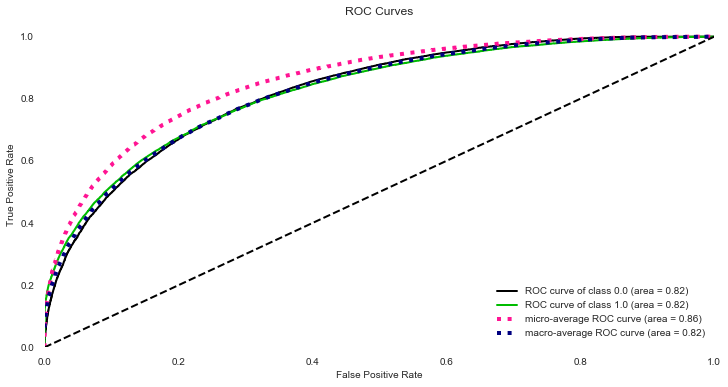

In [205]:
skplt.metrics.plot_roc(train_label, model.predict_proba(train), figsize=(12,6))
plt.show();

#### Classification on Test

In [206]:
clf_pred_test = model.predict_proba(test)[:, 1]
clf_pred_test_class = model.predict(test) 

In [207]:
prf = precision_recall_fscore_support(test_label, clf_pred_test_class, average = 'weighted')
tn, fp, fn, tp = confusion_matrix(test_label, clf_pred_test_class).ravel()
print(tn, fp, fn, tp)
print("Test AUC Score for probabiltity of Target = 1:", roc_auc_score(test_label, clf_pred_test))
print("Test AUC Score for class prediction:", roc_auc_score(test_label, clf_pred_test_class))
print("Train Accuracy Score:", balanced_accuracy_score(test_label,clf_pred_test_class))
print("Weighted Test Precision Score:",prf[0])
print("Weighted Test Recall Score:",prf[1])
print("Weighted Test f1 Score:",prf[2])

Test AUC Score for probabiltity of Target = 1: 0.7873304375092822
Test AUC Score for class prediction: 0.6787574352500202
Train Accuracy Score: 0.6787574352500202
Weighted Test Precision Score: 0.7441482631530983
Weighted Test Recall Score: 0.7503095336359884
Weighted Test f1 Score: 0.7333340258163268


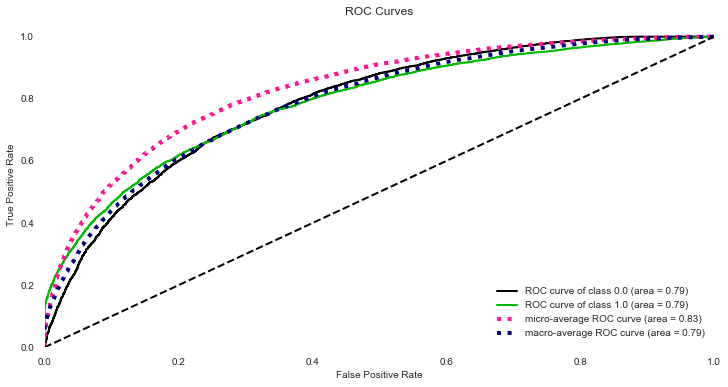

In [208]:
skplt.metrics.plot_roc(test_label, model.predict_proba(test), figsize=(12,6))
plt.show();

### Automated Hyperparamter Tuning

In [225]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5



#### Objective Function

In [226]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

#### Domain

In [227]:
from hyperopt.pyll.stochastic import sample

from hyperopt import hp
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [228]:


# Create a new file and open a connection

OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.21551.
The optimal number of estimators was 606.


#### Optimization Algorithm

In [229]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest
from hyperopt import Trials

# Record results
trials = Trials()



In [230]:
from hyperopt import fmin
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)


100%|█████████████████████████████████████████████| 5/5 [2:48:58<00:00, 2027.68s/trial, best loss: 0.22455040496268874]


In [231]:
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

[{'loss': 0.22455040496268874,
  'hyperparameters': {'boosting_type': 'dart',
   'colsample_bytree': 0.8626451005056668,
   'is_unbalance': False,
   'learning_rate': 0.012325151231583821,
   'min_child_samples': 340,
   'num_leaves': 74,
   'reg_alpha': 0.9201782887682018,
   'reg_lambda': 0.23443102187637055,
   'subsample_for_bin': 40000,
   'subsample': 0.954298028947447,
   'n_estimators': 10000},
  'iteration': 3,
  'train_time': 2803.936367800008,
  'status': 'ok'}]

In [232]:
results = pd.read_csv(OUT_FILE)


In [236]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train, train_label)
    clf_pred_train = model.predict_proba(train)[:, 1]
    clf_pred_train_class = model.predict(train) 
    clf_pred_test = model.predict_proba(test)[:, 1]
    clf_pred_test_class = model.predict(test) 
    
    

    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [238]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.78449 found on iteration 1.
Train AUC Score for probability of Target = 1: 0.8991696364590571
Train AUC Score for class prediction: 0.8102998618743177
Train Accuracy Score: 0.8102998618743176
Weighted Train Precision Score: 0.8243387998406453
Weighted Train Recall Score: 0.8125672508586
Weighted Train f1 Score: 0.8157858281135031
Test AUC Score for probabiltity of Target = 1: 0.7900363255385663
Test AUC Score for class prediction: 0.713243712883968
Train Accuracy Score: 0.713243712883968
Weighted Test Precision Score: 0.7394767219359721
Weighted Test Recall Score: 0.7300866694180768
Weighted Test f1 Score: 0.7335327243784918


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,n_estimators,iteration,score
0,gbdt,0.628081,True,0.014549,35,127,0.757313,0.010116,300000,0.748051,606,1,0.784492
1,dart,0.862645,False,0.012325,340,74,0.920178,0.234431,40000,0.954298,10000,3,0.775450
2,gbdt,0.700654,True,0.403179,105,88,0.908288,0.555427,200000,0.748990,11,5,0.771944
3,dart,0.748835,False,0.205120,45,60,0.293528,0.589675,260000,0.789993,10000,1,0.757441
4,dart,0.879481,True,0.102988,125,96,0.558871,0.626372,120000,0.989849,10000,4,0.754771
5,dart,0.738548,False,0.195828,335,75,0.010304,0.557966,40000,0.546726,10000,2,0.740584


In [242]:
new_results = results.copy()
    # String to dictionary
new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
hyperparameters = new_results.loc[0, 'hyperparameters']
model = lgb.LGBMClassifier(**hyperparameters)

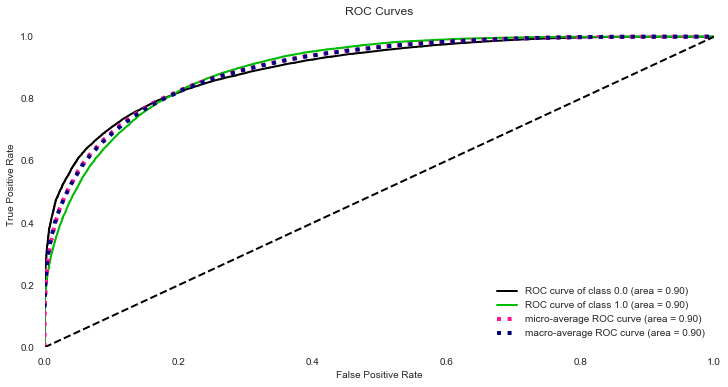

In [243]:
  # Train and make predictions
model.fit(train, train_label)
   


37012 8287 4429 18115
Train AUC Score for probability of Target = 1: 0.8991696364590571
Train AUC Score for class prediction: 0.8102998618743177
Train Accuracy Score: 0.8102998618743176
Weighted Train Precision Score: 0.8243387998406453
Weighted Train Recall Score: 0.8125672508586
Weighted Train f1 Score: 0.8157858281135031


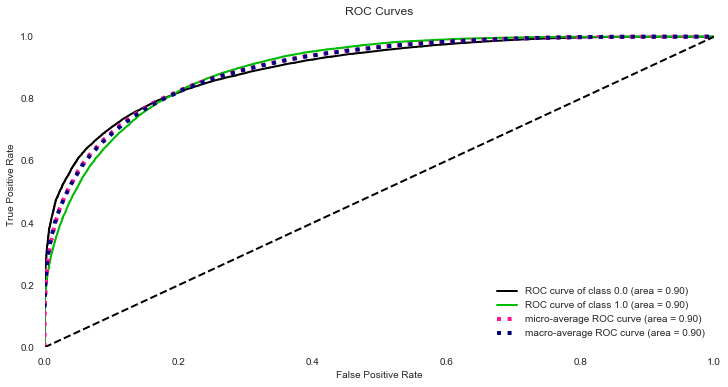

In [250]:
clf_pred_train = model.predict_proba(train)[:, 1]
clf_pred_train_class = model.predict(train) 
clf_pred_test = model.predict_proba(test)[:, 1]
clf_pred_test_class = model.predict(test) 

tn, fp, fn, tp = confusion_matrix(train_label, clf_pred_train_class).ravel()
print(tn, fp, fn, tp)
    
prf = precision_recall_fscore_support(train_label, clf_pred_train_class, average = 'weighted')
print("Train AUC Score for probability of Target = 1:", roc_auc_score(train_label, clf_pred_train))
print("Train AUC Score for class prediction:", roc_auc_score(train_label, clf_pred_train_class))
print("Train Accuracy Score:", balanced_accuracy_score(train_label,clf_pred_train_class))
print("Weighted Train Precision Score:",prf[0])
print("Weighted Train Recall Score:",prf[1])
print("Weighted Train f1 Score:",prf[2])
skplt.metrics.plot_roc(train_label, model.predict_proba(train), figsize=(12,6))
plt.show();

8597 2640 1938 3786
Test AUC Score for probabiltity of Target = 1: 0.7900363255385663
Test AUC Score for class prediction: 0.713243712883968
Train Accuracy Score: 0.713243712883968
Weighted Test Precision Score: 0.7394767219359721
Weighted Test Recall Score: 0.7300866694180768
Weighted Test f1 Score: 0.7335327243784918


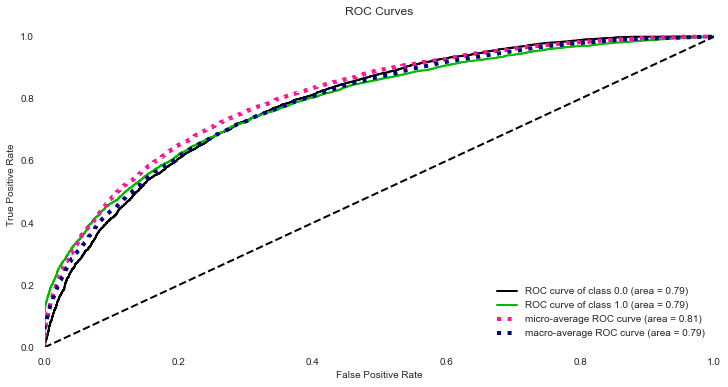

In [251]:
    prf = precision_recall_fscore_support(test_label, clf_pred_test_class, average = 'weighted')
    tn, fp, fn, tp = confusion_matrix(test_label, clf_pred_test_class).ravel()
    print(tn, fp, fn, tp)
    print("Test AUC Score for probabiltity of Target = 1:", roc_auc_score(test_label, clf_pred_test))
    print("Test AUC Score for class prediction:", roc_auc_score(test_label, clf_pred_test_class))
    print("Train Accuracy Score:", balanced_accuracy_score(test_label,clf_pred_test_class))
    print("Weighted Test Precision Score:",prf[0])
    print("Weighted Test Recall Score:",prf[1])
    print("Weighted Test f1 Score:",prf[2])
    

    skplt.metrics.plot_roc(test_label, model.predict_proba(test), figsize=(12,6))
    plt.show();